In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Introduction
Public schools in the US represent a broad cross section of the regional population. They also tend to have robust and consistent collections of data. This data set is from New York City (NYC) public school surveys of the 2011-2012 school year. It consists of 161 columns of information for 363 schools.

# Summary
* Schools with below average assessment of safety and respect have below average results on the SAT.
* Initial analysis shows a negative correlation between the percentage of Hispanic students and SAT results. This relationship is not seen in results on the AP exam. Furthermore, when magnet schools and international schools are removed from the data set, the remaining 90% of schools show a fairly uniform distribution and the correlation is lost.  
* A small group of schools share SAT scores and AP exam values. This could be due to a cohort of students that is shared among the schools. Their influence on the original data set needs to be considered before further analysis is made.

# Data Cleaning

## Read in the data

In [2]:
import pandas as pd
import numpy
import re
import pprint
pd.options.display.float_format = '{:20,.4f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 3000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/var/folders/tf/f9bv6m516pjcr2ytmmh92cw00000gn/T/ipykernel_46725/3674931809.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


## Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/var/folders/tf/f9bv6m516pjcr2ytmmh92cw00000gn/T/ipykernel_46725/3398560250.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


## Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Correlations & Analysis

## Plotting survey correlations

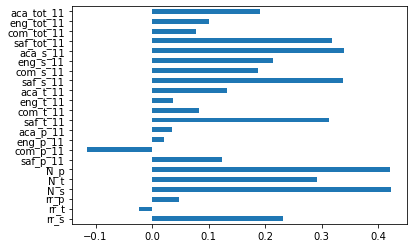

In [10]:
# determine correlations
correlations = combined.corr()
correlations = correlations["sat_score"]

# bar plot for correlations between survey_fields and sat_score
import matplotlib.pyplot as plt
correlations.loc["rr_s":"aca_tot_11"].plot.barh()
plt.show()

### Observations
It looks like the strongest correlations are between the SAT scores and the number of parents or students that respond to the survey. The response rate, on the other hand, is not correlated. This discrepancy might be worth looking at.
<br>
<br>
Additional correlations are between SAT scores and two other factors, the students academic expectations and the perception of safety and respect by students, teachers, and parents. The next two sections look at each.
## SAT Scores & Safety Scores

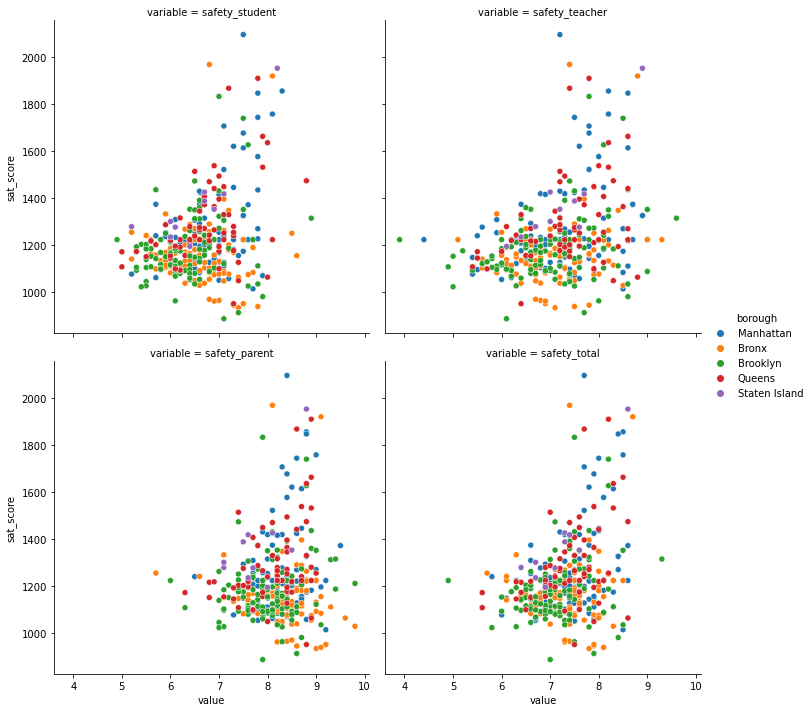

In [11]:
# create melted df from combined preserving school borough & DBN, sat_score,  and safety scores
boroughs_long = combined[["boro", "DBN", "sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
boroughs_columns = ["borough", "DBN", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
boroughs_long.columns = boroughs_columns
boroughs_long = boroughs_long.melt(id_vars=["borough", "DBN", "sat_score"])

# scatter plot with borough, sat_score, and safety scores (0-10)
# plots are for student, teacher, parent, and total safety scores
import seaborn as sns
sns.relplot(data=boroughs_long, x="value", y="sat_score", hue="borough", col="variable", col_wrap=2)
plt.show()

In [12]:
# mean value for sat_score and safety scores, grouped by borough
boroughs_means = combined.groupby("boro").mean()
boroughs_means = boroughs_means[["sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
boroughs_means.reset_index(inplace=True)
boroughs_columns = ["borough", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
boroughs_means.columns = boroughs_columns
display(boroughs_means)

,borough,sat_score,safety_student,safety_teacher,safety_parent,safety_total
0,Bronx,"1,157.5982",6.6066,7.0269,8.3462,7.3226
1,Brooklyn,"1,181.3645",6.3708,6.9858,8.0368,7.1292
2,Manhattan,"1,278.3314",6.8314,7.2878,8.2889,7.4733
3,Queens,"1,286.7530",6.7219,7.3656,8.0984,7.3875
4,Staten Island,"1,382.5000",6.5300,7.2100,7.8000,7.2000


 ### Observations
The scatter plots show two areas influencing the correlation between SAT scores and perceptions of safety and respect. First, the highest SAT scores come from schools with above average perceptions of safety and respect. Second, it looks like most schools have both SAT and safety and respect scores below the median values. It is also interesting that parents have a noticeably higher perception of safety and respect than either teachers or students.
<br>
<br>
Grouping schools by borough and averaging scores paints a different picture. This seems to indicate that SAT scores and perception of safety do not have a strong positive correlation at all. For instance, Staten Island has the highest average SAT scores and Bronx the lowest. However, the student and parent perception of safety and respect scores are higher in the Bronx than in Staten Island. And while Manhattan has mostly the highest safety and respect scores, it ranks in the middle for SAT scores
 ## SAT Scores & Student Academic Expectations

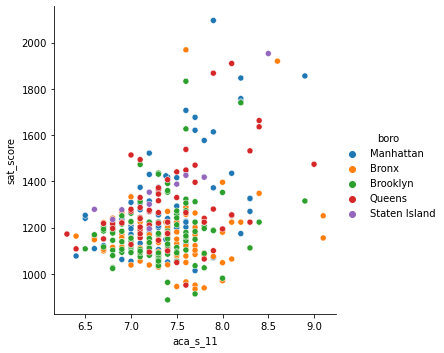

In [13]:
# scatter plot with borough, sat_score, and academic expectations (0-10)
sns.relplot(data=combined, x="aca_s_11", y="sat_score", hue="boro")
plt.show()

### Observations
The academic expectation scatter plot shows similar results to those for perception of safety and respect. Again, there are very few schools in the upper half of the academic expectation scores, and among them about half have better than average SAT scores. Also, we see that most schools have both SAT scores and academic expectations that are below the median value.

## SAT Scores & Demographics on Race/Ethnicity
Taking an objective look at the relationship between race & ethnicity and SAT scores in NYC schools can help in creating an egalitarian public school system that delivers success to all students.

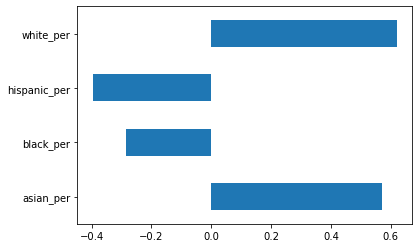

In [14]:
# make bar plot for correlations between race & ethnicity and sat_score
correlations.loc[["asian_per", "black_per", "hispanic_per", "white_per"]].plot.barh()
plt.show()

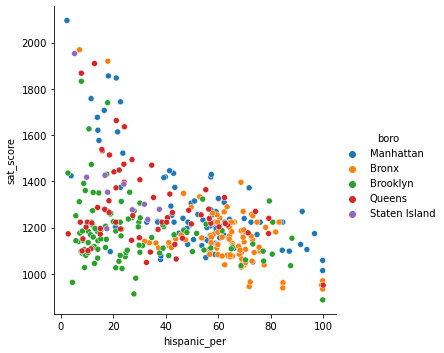

In [15]:
# scatter plot for sat_scores and percent Hispanic
sns.relplot(data=combined, x="hispanic_per", y="sat_score", hue="boro")
plt.show()

### Observations
The bar chart for race & ethnicity paints a stark picture, showing a strong negative correlation between SAT scores and the percentage of Hispanic or Black students in the school. That being said, the scatter plot suggests something a little more nuanced.
<br>
<br>
The highest SAT scores (over 1500) occur in schools with a low percentage of Hispanic students, but this is only about 6% of the schools in the data set. Also, there are about 5-10 schools that show close to 100% Hispanic student populations. These schools do have some of the lowest SAT scores, it is important to find out why. Importantly though, it looks like most of the schools show a more even distribution of SAT scores below 1500 while having a percentage of Hispanic students ranging up to about 95%.
<br>
<br>
Additionally, almost all the schools in the Bronx have more than half the student population identifying as Hispanic. There are just a few with less than 40% Hispanic, and two of these schools score the highest SAT averages. 
<br>
<br>
That creates three groups of schools, with one group being divided again in two. The following sections take a look at each.
## Group 1, High SAT scores

In [16]:
# create high_sat data set
high_sat = combined["Name"][combined["sat_score"] > 1500]
high_sat = high_sat.str.strip()
high_sat_bronx = combined["Name"][(combined["sat_score"] > 1500) & (combined["boro"]=="Bronx")]
display(high_sat)
print(len(high_sat))
print(len(combined))
display(high_sat_bronx)

4           NEW EXPLORATIONS INTO SCIENCE TECH AND MATH
5                        BARD HIGH SCHOOL EARLY COLLEGE
22             PROFESSIONAL PERFORMING ARTS HIGH SCHOOL
23                    BARUCH COLLEGE CAMPUS HIGH SCHOOL
24             NYC LAB SCHOOL FOR COLLABORATIVE STUDIES
26                        ELEANOR ROOSEVELT HIGH SCHOOL
27                               MILLENNIUM HIGH SCHOOL
37                               STUYVESANT HIGH SCHOOL
60                                   BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART
79      HIGH SCHOOL FOR MATHEMATICS SCI AND ENGINEERING
151                        BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEG
187                      BROOKLYN TECHNICAL HIGH SCHOOL
198                                      BROOKLYN LATIN
278      LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES
287                   BARD HIGH SCHOOL EARLY COLLEGE II
302                         TOWNSEND HARRIS HIGH

24
363


151    BRONX HIGH SCHOOL OF SCIENCE                    
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEG
Name: Name, dtype: object

### Observations
Sure enough, most of these schools sound pretty brainy. The two in the Bronx included.
## Group 2, Hispanic Student Population Over 95%

In [17]:
# create hispanic_per_95 data set
import numpy as np
columns = combined.iloc[:,[0,1,6,34,8,9,10,60,70]]
hispanic_per_95 = columns[combined["hispanic_per"] > 95]
display(hispanic_per_95)
print(combined["sat_score"].max())
print(combined["sat_score"].min())
# print(np.array_split(range(887,2096), 10))
# [x.tolist() for x in np.array_split(range(10), 3)]
# print([x.tolist() for x in np.array_split(range(887,2096), 3)])

,DBN,SCHOOL NAME,sat_score,NUMBER OF STUDENTS / SEATS FILLED,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,ell_percent,hispanic_per
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,"1,058.0000",107.1875,67.0000,102.0000,59.0000,72.6000,99.8000
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,"1,174.0000",74.2000,129.0288,197.0385,153.4500,19.6000,96.7000
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,"1,014.0000",163.6154,88.0000,138.0000,73.0000,89.6000,99.8000
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0000,110.2143,20.0000,20.0000,20.0000,86.6000,99.4000
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0000,141.6923,55.0000,73.0000,45.0000,79.9000,99.8000
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0000,119.1538,129.0288,197.0385,153.4500,92.9000,99.8000
253,19K583,MULTICULTURAL HIGH SCHOOL,887.0000,115.1667,44.0000,44.0000,39.0000,94.6000,99.8000
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0000,116.0667,129.0288,197.0385,153.4500,91.3000,100.0000


2096.0
887.0


### Observations
This set of schools has the highest percentage of students identifying as Hispanic. The SAT scores all fall within the bottom quartile, with five of them scoring in the lowest tenth all the schools. They are further differentiated by having high percentages of students where English is a second language. The exception to this is the Washington Heights Expeditionary Learning School. All of the schools show a good percentage of passing scores on AP Exams.

Some people would consider AP Exam pass rate as a proxy for academic achievement. This combined with the large number of ELL students suggests that these SAT scores may be non-representational for some groups of NYC public school students.
## Group 3, The Majority of the Schools

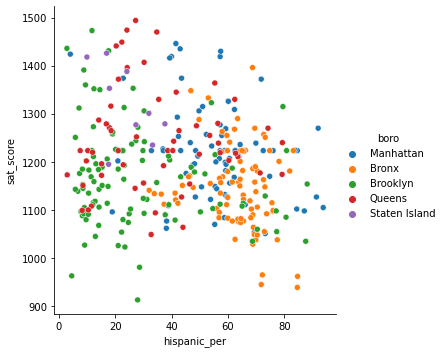

In [18]:
# create majority data set
majority = combined[(combined["sat_score"] < 1500) & (combined["hispanic_per"] < 95)]

# scatter plot for sat_scores and majority of schools
sns.relplot(data=majority, x="hispanic_per", y="sat_score", hue="boro")
plt.show()

331


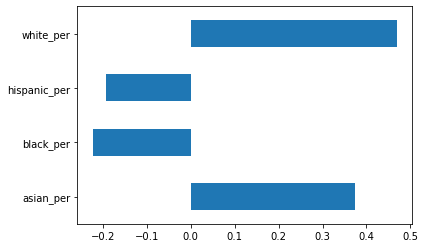

In [19]:
# correlations between race & ethnicity and sat_score in the majority of schools
majority_correlations = majority.corr()
majority_correlations = majority_correlations["sat_score"]
print(len(majority))
majority_correlations.loc[["asian_per", "black_per", "hispanic_per", "white_per"]].plot.barh()
plt.show()

### Observations
Removing the schools with the highest percentage of Hispanic students (this includes many international and ELL students) and the schools with SAT scores over 1500 shows a more uniform distribution of SAT scores but still accounts for 91% of the schools in the original data set. The correlation between SAT scores and percentage of students identifying as Hispanic drops to less than -0.2.
## SAT Scores & Gender
Information on student gender percentages is also available.

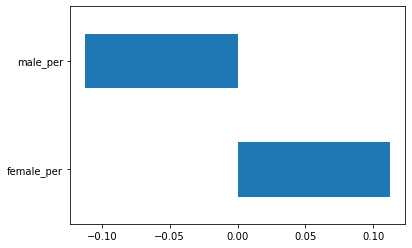

In [20]:
# bar plot for correlations between gender percentage and sat_score
correlations.loc[["female_per", "male_per"]].plot.barh()
plt.show()

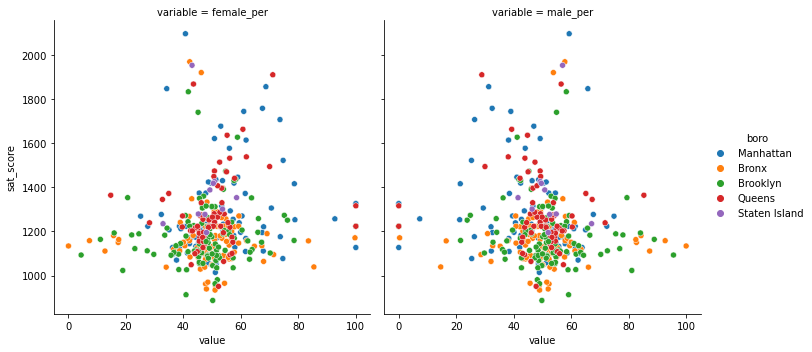

In [21]:
# scatter plots for sat_scores and gender
import matplotlib.pyplot as plt
genders = combined[["boro", "DBN", "SCHOOL NAME", "sat_score", "female_per", "male_per"]]
genders_melt = genders.melt(id_vars=["boro", "DBN", "SCHOOL NAME", "sat_score"])
sns.relplot(data=genders_melt, x="value", y="sat_score", hue="boro", col="variable")
plt.show()

In [22]:
# caluculate percentage female to male
all_the_kids = combined["NUMBER OF STUDENTS / SEATS FILLED"]
per_female = combined["female_per"].mean()
per_male = combined["male_per"].mean()
print("Total students =", all_the_kids.sum())
print("Percent female =", per_female)
print("Percent male =", per_male)

Total students = 62349.76177031602
Percent female = 50.62066115702485
Percent male = 49.37851239669419


In [23]:
# create sat_score over 1700 data set with female and male percentages
smart_kids = genders.iloc[:,2:6][genders["sat_score"] > 1700]
display(smart_kids)

,SCHOOL NAME,sat_score,female_per,male_per
5,BARD HIGH SCHOOL EARLY COLLEGE,"1,856.0000",68.7000,31.3000
26,ELEANOR ROOSEVELT HIGH SCHOOL,"1,758.0000",67.5000,32.5000
37,STUYVESANT HIGH SCHOOL,"2,096.0000",40.7000,59.3000
60,BEACON HIGH SCHOOL,"1,744.0000",61.0000,39.0000
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,"1,707.0000",73.6000,26.4000
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...","1,847.0000",34.2000,65.8000
151,BRONX HIGH SCHOOL OF SCIENCE,"1,969.0000",42.2000,57.8000
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,"1,920.0000",46.2000,53.8000
187,BROOKLYN TECHNICAL HIGH SCHOOL,"1,833.0000",41.7000,58.3000
198,"BROOKLYN LATIN SCHOOL, THE","1,740.0000",45.1000,54.9000


### Observations
Three things from the results stand out.
<br>
<br>
First, the ratio of male to female students seems to have little to no effect on SAT scores. 
<br>
<br>
Second, among the schools with SAT scores over 1700, there are five with over 60% female students and two with over 70%. There is only one with over 60% male students and none with over 70%. The two schools with the highest number of females are Townsend Harris High School (consistently ranked among the 100 best high schools in America) and LaGuardia High School. Both are magnet schools. The two schools with the highest average SAT scores are Stuyvesant High School (59% male) and Bronx High School of Science (58% male). Both of these are also magnet schools.
<br>
<br>
Third, particularly interesting from a stats point of view, is that the gender break down among all the schools is so close to fifty-fifty. About 50.62% of the students are female and 49.37% male.
## SAT Scores & AP Exams
Advanced Placement (AP) courses are college preparatory classes in the US, and are scored on a 1-5 scale. Scores of 3 and above often receive credit in US colleges and universities. AP Exam scores can be seen as a proxy for academic success, similarly to SAT scores. This data set provides a good look at how the two are related.

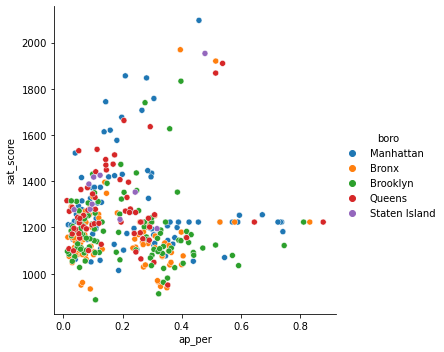

In [24]:
# create a column with percent of total sudents who took ap exams
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
# scatter plot for ap_per and gender
sns.relplot(data=combined, x="ap_per", y="sat_score", hue="boro")
plt.show()

In [25]:
# examine schools with high percentage of students taking ap exam
all_ap = combined[["SCHOOL NAME", "sat_score", "ap_per"]][combined["ap_per"] > 0.5]
display(all_ap)

,SCHOOL NAME,sat_score,ap_per
6,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,"1,182.0000",0.7415
20,THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY,"1,223.4388",0.5288
31,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,"1,223.4388",0.7373
32,HUDSON HIGH SCHOOL OF LEARNING TECHNOLOGIES,"1,223.4388",0.5709
33,INTERNATIONAL HIGH SCHOOL AT UNION SQUARE,"1,223.4388",0.7331
39,UNITY CENTER FOR URBAN TECHNOLOGIES,"1,070.0000",0.5444
43,REPERTORY COMPANY HIGH SCHOOL FOR THEATRE ARTS,"1,253.0000",0.5946
50,HUMANITIES PREPARATORY ACADEMY,"1,255.0000",0.6720
59,FRANK MCCOURT HIGH SCHOOL,"1,223.4388",0.5892
83,HIGH SCHOOL FOR EXCELLENCE AND INNOVATION,"1,223.4388",0.7249


In [26]:
# schools with sat_score == 1223.4388
twelvetwentythree = combined[(1223 < combined["sat_score"]) & (combined["sat_score"] < 1224)]
display(twelvetwentythree)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Demographic,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,grade3,grade4,grade5,grade6,grade7,grade8,grade9,grade10,grade11,grade12,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,saf_t_11,com_t_11,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
18,02M392,MANHATTAN BUSINESS ACADEMY,s,404.1194,419.6567,399.6627,"1,223.4388",0,129.0288,197.0385,153.4500,0,0,0,193.8710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0000,57.7143,2.2857,25.2571,23.4286,27.0000,0.0000,MANHATTAN BUSINESS ACADEMY,20112012,0.0000,64.0000,332,,,,,,,,,,,148,91,93,,33.0000,9.9000,46.0000,13.9000,38,2,22,6.6000,98,29.5000,195,58.7000,16,4.8000,196.0000,59.0000,136.0000,41.0000,83.0000,94,40,172.0000,17.0000,81.0000,8.3000,8.0000,7.6000,8.2000,7.4000,7.5000,7.5000,8.2000,6.9000,6.4000,6.8000,7.5000,7.5000,7.3000,7.3000,8.0000,02M392,MANHATTAN BUSINESS ACADEMY,Manhattan,M440,212-647-1983,212-647-1989,9,12,0,12.0000,"M11, M14A, M14D, M20, M23, M7","1 to 18th St ; 2, 3, F, M to 14th St ; A, C, E...",351 West 18 Street,New York,NY,10011,www.manhattanbusinessacademy.org,426.0000,Bayard Rustin Educational Campus,0,We are a small community committed to creating...,"4 years of core courses in Math, Science, Engl...",Spanish,Statistics,0,"French, Spanish",Burton Chill Programs: Snowboarding (Winter) a...,"Baseball, Basketball & JV Basketball, Soccer, ...","Basketball & JV Basketball, Soccer, Softball, ...",Bowling,"Intramural Basketball, Cheerleading",Virtual Enterprises International,Mount Sinai,"Baruch College College Now, BMCC College Now, ...",Student Press Initiative,"Futures and Option: Career Essentials Program,...","Deloitte, Advent Solutions",0,Institute for Student Achievement,"After-school tutoring, PSAT and SAT prep class...",0,8:30 AM,3:15 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Manhattan students or residents wh...,Then to New York City residents who attend an ...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0.0000,0.0000,0.0000,"351 West 18 Street\nNew York, NY 10

In [27]:
combined["Num of SAT Test Takers"].value_counts().head()

s     28
54     8
72     8
48     7
63     6
Name: Num of SAT Test Takers, dtype: int64

### Observations
The scatter plot showing SAT scores compared to the percent of students taking AP exams showed some interesting patterns.
<br>
<br>
First, to answer the primary question, there does not appear to be a strong correlation between the two values. The schools with the highest SAT scores do have a large number of students taking AP exams. But there are many more schools with the same number of students taking the AP exam that have average SAT scores.
<br>
<br>
Second, there are two large groups of schools with similar SAT scores but notably different numbers of AP exam takers. There is a group that has about 5-15% of the students taking the AP exam and another with about 20-30%. This is a little interesting.
<br>
<br>
Third is a grouping of schools with identical SAT scores. Looking at the data set shows 28 schools with a SAT score of 1223.4388. This line shows up in the other scatter plots but is very obvious in this one. These schools also have the same numbers of AP exam test takers, AP exams taken, and AP scores of 3,4, or 5. They all also have the only non numeric value in the `Num of SAT Test Takers` column, namely `s`. Each of the groups of students does represent a different percentage of students in the school.

# Conclusions

This initial look at academic and societal data for NYC schools suggests that the relationship between subgroups can be more nuanced than might first appear.
* Schools that have high average SAT scores also have high safety and respect scores. While many schools with high safety and respect scores have average SAT scores, none of the schools in the bottom half of this group score above average SAT scores. This is a very important finding.
* There doesn't seem to be a very strong connection in most high schools between high SAT scores and common demographic groups. Removing magnet schools and schools where the SAT has less emphasis or relevance (such as locations with very high percentages of international students) normalizes the distribution. It would be interesting to see what would happen to the overall data set if these students were re-introduced to schools in the same geographic area.
* About 7% of the schools in the data set appear to share a group of students taking the SAT and AP exams. These schools represent key demographic data but their influence on the overall data set needs to be considered before further analysis is made.